In [1]:
!pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 70.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.feature_selection import f_classif, mutual_info_classif
import nltk
from nltk.tokenize import sent_tokenize
import spacy
import string
from nltk.corpus import stopwords
import re
from textblob import TextBlob
import textstat
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

In [3]:
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
train_df = pd.read_csv("/kaggle/input/xai-updatedataset/train_df (1).csv").sample(2000)
test_df = pd.read_csv("/kaggle/input/xai-updatedataset/test_df (1).csv").sample(700)

In [5]:
X_train = train_df["text"]
y_train = train_df["label"]
X_test = test_df["text"]
y_test = test_df["label"]

In [6]:
vectorizer = TfidfVectorizer(max_features=10000)
X_train_vec = vectorizer.fit_transform(X_train).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()

In [7]:
def extract_features(text):
    doc = nlp(text)
    
    words = [token.text for token in doc if token.is_alpha]
    sentences = sent_tokenize(text)
    word_count = len(words)
    char_count = sum(len(word) for word in words)
    sentence_count = len(sentences) if sentences else 1  # Avoid division by zero
    
    avg_sentence_length = word_count / sentence_count if sentence_count else 0

    hapax_legomena = len([word for word, count in Counter(words).items() if count == 1])
    
    flesch_reading_ease = textstat.flesch_reading_ease(text)
    flesch_grade_level = textstat.flesch_kincaid_grade(text)
    
    punctuation_count = sum(1 for char in text if char in string.punctuation)
    
    personal_pronoun_count = sum(1 for token in doc if token.tag_ in ['PRP', 'PRP$'])
    
    pos_counts = Counter(token.pos_ for token in doc)
    noun_count = pos_counts.get("NOUN", 0)
    verb_count = pos_counts.get("VERB", 0)
    adv_count = pos_counts.get("ADV", 0)
    
    return {
        "word_count": word_count,
        "char_count": char_count,
        "sentence_count": sentence_count,
        "avg_sentence_length": avg_sentence_length,
        "hapax_legomena": hapax_legomena,
        "flesch_reading_ease": flesch_reading_ease,
        "flesch_grade_level": flesch_grade_level,
        "punctuation_count": punctuation_count,
        "personal_pronoun_count": personal_pronoun_count,
        "noun_count": noun_count,
        "verb_count": verb_count,
        "adv_count": adv_count
    }

In [8]:
feature_columns = [
    "punctuation_count",
    "word_count",
    "sentence_count",
    "verb_count",
    "char_count",
    "adv_count",
    "hapax_legomena",
    "noun_count",
    "flesch_reading_ease",
    "personal_pronoun_count",
    "avg_sentence_length",
    "flesch_grade_level"
]

In [9]:
df_feature = pd.DataFrame()
df_feature[feature_columns] = train_df["text"].apply(lambda x: pd.Series(extract_features(x)))
X_train = np.hstack((X_train_vec, df_feature))

In [10]:
df_test_features = pd.DataFrame()
df_test_features[feature_columns] = test_df['text'].apply(extract_features).apply(pd.Series)
X_test = np.hstack((X_test_vec, df_test_features))

In [11]:
xgb_model = XGBClassifier(eval_metric='logloss', random_state=47)
svm_model = SVC(probability=True)
nb_model = GaussianNB()
rf_model = RandomForestClassifier(random_state=47)
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

models = {
    'XGBoost': xgb_model,
    'SVM': svm_model,
    'Naive Bayes': nb_model,
    'Random Forest': rf_model,
    'GradientBoosting': gbc
}

Evaluation of model XGBoost
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       377
           1       0.97      0.94      0.96       323

    accuracy                           0.96       700
   macro avg       0.96      0.96      0.96       700
weighted avg       0.96      0.96      0.96       700



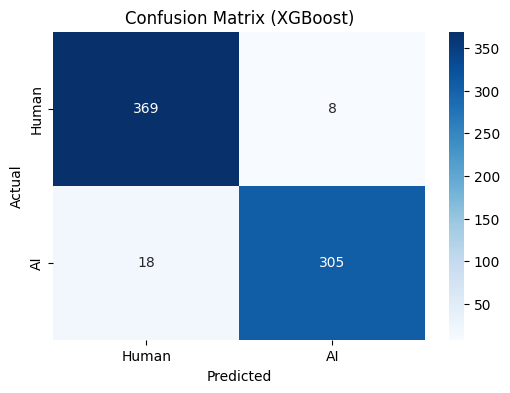

Evaluation of model SVM
              precision    recall  f1-score   support

           0       0.80      0.64      0.71       377
           1       0.66      0.81      0.73       323

    accuracy                           0.72       700
   macro avg       0.73      0.73      0.72       700
weighted avg       0.74      0.72      0.72       700



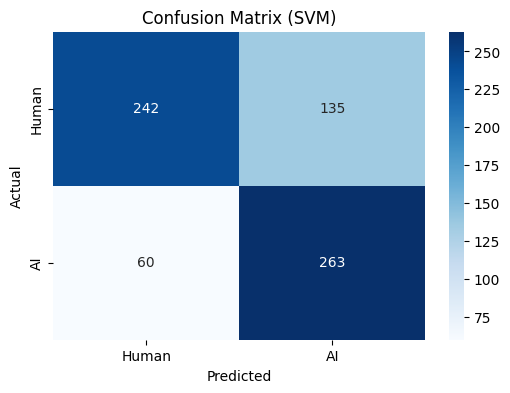

Evaluation of model Naive Bayes
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       377
           1       0.83      0.73      0.78       323

    accuracy                           0.81       700
   macro avg       0.81      0.80      0.81       700
weighted avg       0.81      0.81      0.81       700



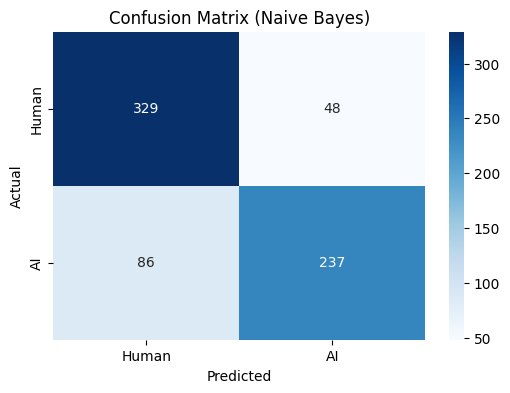

Evaluation of model Random Forest
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       377
           1       0.98      0.87      0.92       323

    accuracy                           0.93       700
   macro avg       0.94      0.93      0.93       700
weighted avg       0.94      0.93      0.93       700



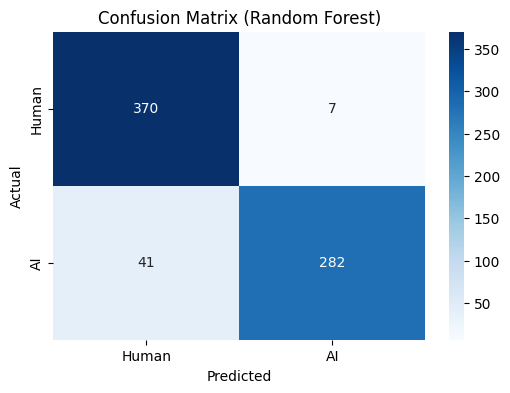

Evaluation of model GradientBoosting
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       377
           1       0.96      0.93      0.94       323

    accuracy                           0.95       700
   macro avg       0.95      0.95      0.95       700
weighted avg       0.95      0.95      0.95       700



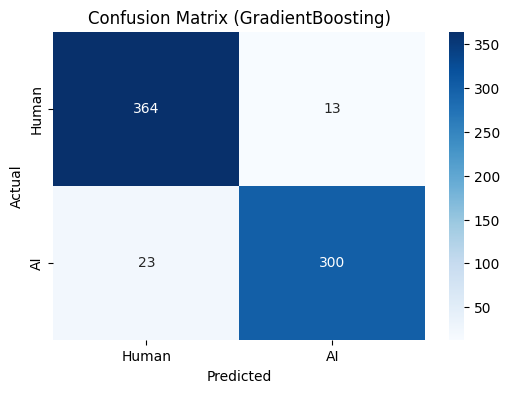

In [12]:
results = []

for model_name, model in models.items():
    # Train model
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    # y_proba = model.predict_proba(X_test)[:, 1]
    
    print(f"Evaluation of model {model_name}")
    # roc_auc = roc_auc_score(y_test, y_proba)
    # print(f"ROC AUC Score: {roc_auc:.4f}")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    
    
    # Plotting the Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion Matrix ({model_name})')
    plt.show()

In [13]:
coling_df = pd.read_csv("/kaggle/input/train-coling/train_COLING.csv").sample(700)
X = coling_df["text"]
y = coling_df["label"]
x_vec = vectorizer.transform(X).toarray()

In [14]:
df_coling_features = pd.DataFrame()
df_coling_features = coling_df['text'].apply(extract_features).apply(pd.Series)
X_Coling = np.hstack((x_vec, df_coling_features))

Evaluation of model XGBoost
ROC AUC Score: 0.6653
              precision    recall  f1-score   support

           0       0.50      0.63      0.56       279
           1       0.70      0.58      0.63       421

    accuracy                           0.60       700
   macro avg       0.60      0.60      0.59       700
weighted avg       0.62      0.60      0.60       700



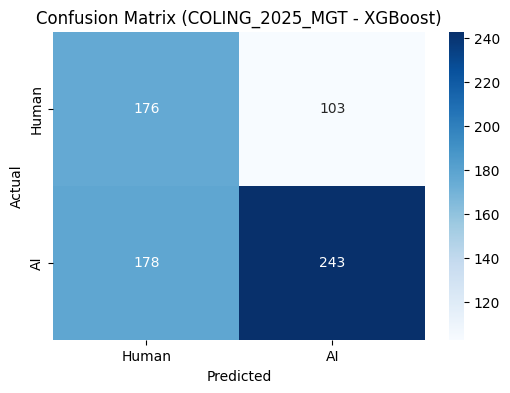

Evaluation of model SVM
ROC AUC Score: 0.5125
              precision    recall  f1-score   support

           0       0.44      0.31      0.36       279
           1       0.62      0.74      0.67       421

    accuracy                           0.57       700
   macro avg       0.53      0.52      0.52       700
weighted avg       0.55      0.57      0.55       700



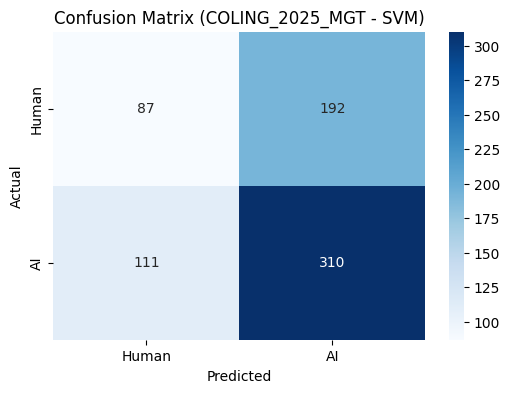

Evaluation of model Naive Bayes
ROC AUC Score: 0.5860
              precision    recall  f1-score   support

           0       0.45      0.61      0.52       279
           1       0.66      0.50      0.57       421

    accuracy                           0.55       700
   macro avg       0.56      0.56      0.54       700
weighted avg       0.58      0.55      0.55       700



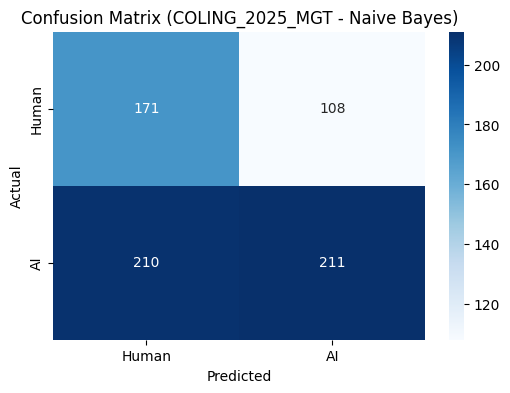

Evaluation of model Random Forest
ROC AUC Score: 0.6252
              precision    recall  f1-score   support

           0       0.49      0.49      0.49       279
           1       0.66      0.66      0.66       421

    accuracy                           0.59       700
   macro avg       0.57      0.58      0.57       700
weighted avg       0.59      0.59      0.59       700



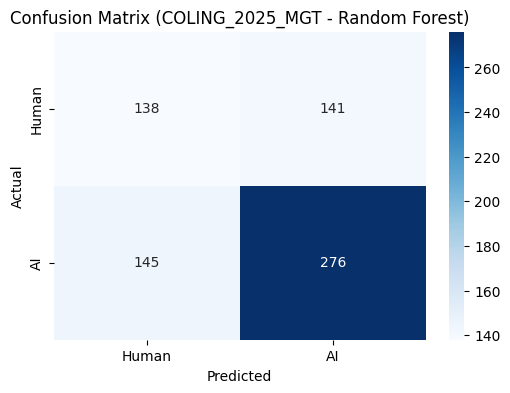

Evaluation of model GradientBoosting
ROC AUC Score: 0.6400
              precision    recall  f1-score   support

           0       0.49      0.59      0.54       279
           1       0.69      0.59      0.63       421

    accuracy                           0.59       700
   macro avg       0.59      0.59      0.59       700
weighted avg       0.61      0.59      0.60       700



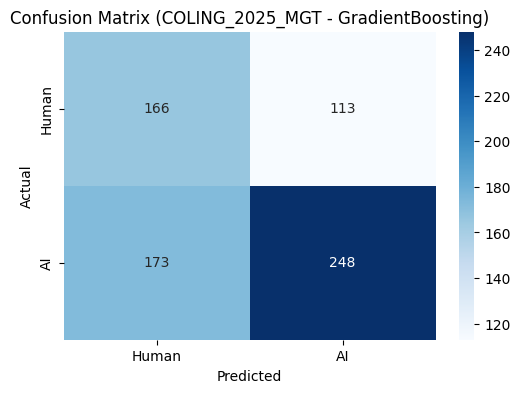

In [15]:
for model_name, model in models.items():
    y_pred = model.predict(X_Coling)
    y_proba = model.predict_proba(X_Coling)[:, 1]
    
    print(f"Evaluation of model {model_name}")
    roc_auc = roc_auc_score(y, y_proba)
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print(classification_report(y, y_pred))
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y, y_pred)

    
    
    # Plotting the Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion Matrix (COLING_2025_MGT - {model_name})')
    plt.show()

In [16]:
pan_df = pd.read_csv("/kaggle/input/train-coling/train_COLING.csv").sample(700)
X = pan_df["text"]
y = pan_df["label"]
x_pan_vec = vectorizer.transform(X).toarray()

In [17]:
df_pan_features = pd.DataFrame()
df_pan_features = pan_df['text'].apply(extract_features).apply(pd.Series)
X_pan = np.hstack((x_vec, df_pan_features))

Evaluation of model XGBoost
              precision    recall  f1-score   support

           0       0.43      0.56      0.49       259
           1       0.68      0.56      0.61       441

    accuracy                           0.56       700
   macro avg       0.56      0.56      0.55       700
weighted avg       0.59      0.56      0.57       700



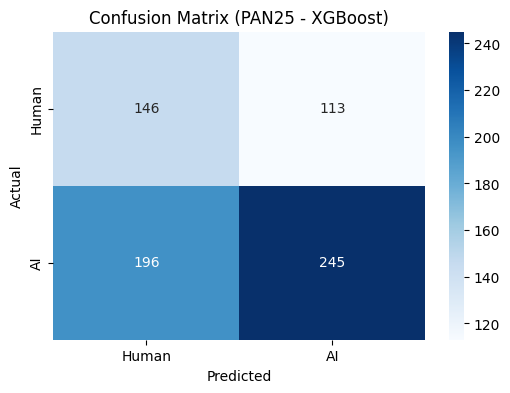

Evaluation of model SVM
              precision    recall  f1-score   support

           0       0.42      0.30      0.35       259
           1       0.65      0.76      0.70       441

    accuracy                           0.59       700
   macro avg       0.54      0.53      0.53       700
weighted avg       0.56      0.59      0.57       700



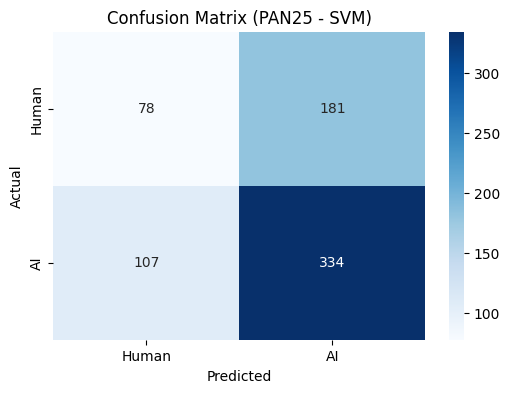

Evaluation of model Naive Bayes
              precision    recall  f1-score   support

           0       0.39      0.61      0.48       259
           1       0.66      0.45      0.53       441

    accuracy                           0.51       700
   macro avg       0.53      0.53      0.51       700
weighted avg       0.56      0.51      0.51       700



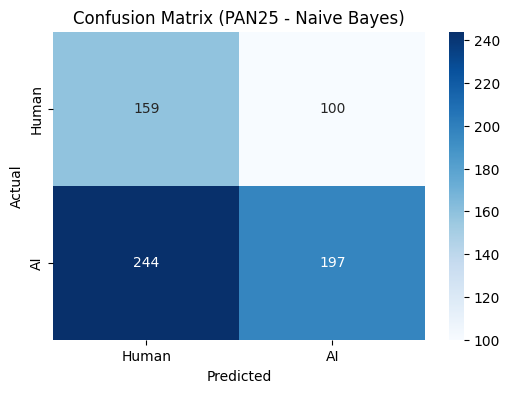

Evaluation of model Random Forest
              precision    recall  f1-score   support

           0       0.42      0.48      0.45       259
           1       0.67      0.61      0.64       441

    accuracy                           0.56       700
   macro avg       0.54      0.54      0.54       700
weighted avg       0.57      0.56      0.57       700



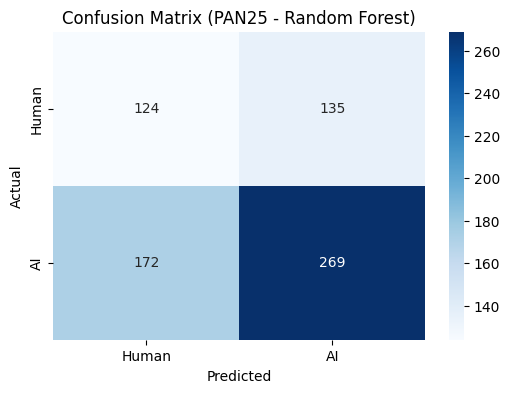

Evaluation of model GradientBoosting
              precision    recall  f1-score   support

           0       0.44      0.51      0.47       259
           1       0.68      0.63      0.65       441

    accuracy                           0.58       700
   macro avg       0.56      0.57      0.56       700
weighted avg       0.59      0.58      0.59       700



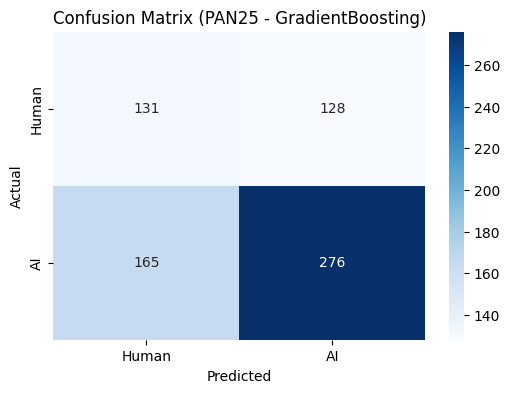

In [18]:
for model_name, model in models.items():
    y_pred = model.predict(X_pan)
    # y_proba = model.predict_proba(X_pan)[:, 1]
    
    print(f"Evaluation of model {model_name}")
    # roc_auc = roc_auc_score(y, y_proba)
    # print(f"ROC AUC Score: {roc_auc:.4f}")
    print(classification_report(y, y_pred))
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y, y_pred)

    
    
    # Plotting the Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion Matrix (PAN25 - {model_name})')
    plt.show()